In [1]:
import numpy as np
import pandas as pd
import keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Conv1D, MaxPooling1D, Dropout
from keras.models import Model
import nlpaug
# import nlpaug.augmenter.text as nat
# import nlpaug.augmenter.text as nat
import nlpaug.augmenter.word.word_embs as nat
import random

import os
import glob



df = pd.read_csv('deceptive-opinion.csv')
pd.set_option('display.max_colwidth', None)







2023-04-10 15:08:27.206807: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df

,deceptive,hotel,polarity,source,text
0,truthful,conrad,positive,TripAdvisor,"We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n"
1,truthful,hyatt,positive,TripAdvisor,"Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n"
2,truthful,hyatt,positive,TripAdvisor,"This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the Hyatt Regency in late October 2007 for one night while visiting a friend and her husband from out of town. This hotel is perfect, IMO. Easy check in and check out. Lovely, clean, comfortable rooms with great views of the city. I know this area pretty well and it's very convenient to many downtown Chicago attractions. We had dinner and went clubing with our friends around Division St.. We had no problems getting cabs back and forth to the Hyatt and there's even public transportation right near by but we didn't bother since we only needed cabs from and to the hotel. Parking, as is usual for Chicago, was expensive but we were able to get our car out quickly (however, we left on a Sunday morning, not exactly a high traffic time although it was a Bears homegame day, so a bit busier than usual I would think). No problems at all and the best part is that we got a rate of $100 through Hotwire, a downright steal for this area of Chicago and the quality of the hotel. \n"
3,truthful,omni,positive,TripAdvisor,"The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high level of quality, the Omni delivers. Check in for myself and a whole group of people with me was under 3 minutes, the staff had plentiful recommendations for dining and events, and the rooms are some of the largest you'll find at this price range in Chicago. Even the 'standard' room has a separate living area and work desk. The fitness center has free weights, weight machines, and two rows of cardio equipment. I shared the room with 7 others and did not feel cramped in any way! All in all, a great property! \n"
4,truthful,hyatt,positive,TripAdvisor,"I asked for a high floor away from the elevator and that is what I got. The room was pleasantly decorated, functional and very clean. I didn't need a whole lot of service but when I did they were pleasant and prompt. I used the fitness center which was well equipped and everything was in working order. It is in a great location at one end of the Michigan Avenue shopping district. \n"
...,...,...,...,...,...
1595,deceptive,intercontinental,negative,MTurk,"Problems started when I booked the InterContinental Chicago online at the hotel's site, and got a server error. Somehow I managed to get my reservation, and wish I had looked elsewhere on this great Chicago street, filled with plenty of other options. The server errors continued at check in and didn't let up. I was on a holiday weekend, but far too many others must have been pushy conventioneers, and I had trouble getting served. The hotel is enormous and doesn't give a sense of comfort. The health facilities are also just too big, so noisy and crowded. And Internet access was $18 a day, kind of surprising when I can go

In [3]:
df[df.isnull()].count()

deceptive    0
hotel        0
polarity     0
source       0
text         0
dtype: int64

<AxesSubplot:xlabel='deceptive', ylabel='count'>

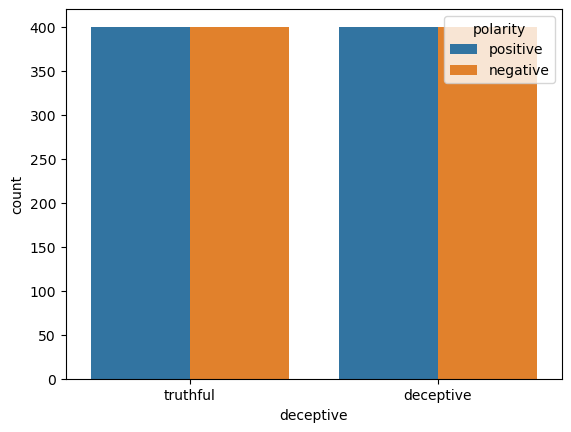

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x=df['deceptive'], hue='polarity', data = df)

In [5]:
df=df.drop(['hotel'],axis=1)


In [6]:
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import re
import string 
def text_cleaning(text):
    '''
        Make text lowercase, remove text in square brackets, remove link, remove special characters, 
        and remove words containing numbers.
    '''
    
    text = text.lower()
    text = re.sub('\[.*?\]','',text)
    text = re.sub('\\W'," ", text)
    text = re.sub('https?://\S+|www\.\S+','',text)
    text = re.sub('<.*?>+','',text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    return text


In [7]:
df['text']=df['text'].apply(text_cleaning)


In [8]:
df

,deceptive,polarity,source,text
0,truthful,positive,TripAdvisor,we stayed for a one night getaway with family on a thursday triple aaa rate of was a steal floor room complete with plasma tv bose stereo voss and evian water and gorgeous bathroom no tub but was fine for us concierge was very helpful you cannot beat this location only flaw was breakfast was pricey and service was very very slow for four kids and four adults on a friday morning even though there were only two other tables in the restaurant food was very good so it was worth the wait i would return in a heartbeat a gem in chicago
1,truthful,positive,TripAdvisor,triple a rate with upgrade to view room was less than which also included breakfast vouchers had a great view of river lake wrigley bldg tribune bldg most major restaurants shopping sightseeing attractions within walking distance large room with a very comfortable bed
2,truthful,positive,TripAdvisor,this comes a little late as i m finally catching up on my reviews from the past several months a dear friend and i stayed at the hyatt regency in late october for one night while visiting a friend and her husband from out of town this hotel is perfect imo easy check in and check out lovely clean comfortable rooms with great views of the city i know this area pretty well and it s very convenient to many downtown chicago attractions we had dinner and went clubing with our friends around division st we had no problems getting cabs back and forth to the hyatt and there s even public transportation right near by but we didn t bother since we only needed cabs from and to the hotel parking as is usual for chicago was expensive but we were able to get our car out quickly however we left on a sunday morning not exactly a high traffic time although it was a bears homegame day so a bit busier than usual i would think no problems at all and the best part is that we got a rate of through hotwire a downright steal for this area of chicago and the quality of the hotel
3,truthful,positive,TripAdvisor,the omni chicago really delivers on all fronts from the spaciousness of the rooms to the helpful staff to the prized location on michigan avenue while this address in chicago requires a high level of quality the omni delivers check in for myself and a whole group of people with me was under minutes the staff had plentiful recommendations for dining and events and the rooms are some of the largest you ll find at this price range in chicago even the standard room has a separate living area and work desk the fitness center has free weights weight machines and two rows of cardio equipment i shared the room with others and did not feel cramped in any way all in all a great property
4,truthful,positive,TripAdvisor,i asked for a high floor away from the elevator and that is what i got the room was pleasantly decorated functional and very clean i didn t need a whole lot of service but when i did they were pleasant and prompt i used the fitness center which was well equipped and everything was in working order it is in a great location at one end of the michigan avenue shopping district
...,...,...,...,...
1595,deceptive,negative,MTurk,problems started when i booked the intercontinental chicago online at the hotel s site and got a server error somehow i managed to get my reservation and wish i had looked elsewhere on this great chicago street filled with plenty of other options the server errors continued at check in and didn t let up i was on a holiday weekend but far too many others must have been pushy conventioneers and i had trouble getting served the hotel is enormous and doesn t give a sense of comfort the health facilities are also just too big so noisy and crowded and internet access was a day kind of surprising when i can go around the corner to a starbucks next time i ll pick a more intimate place nearby without so many server errors
1596,deceptive,negative,MTurk,the amalfi hotel has a beautiful website and interior decorating but

In [9]:
import nltk 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/deth/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
sentences=df['text'].values
y=df['deceptive'].values


In [11]:
y

array(['truthful', 'truthful', 'truthful', ..., 'deceptive', 'deceptive',
       'deceptive'], dtype=object)

In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y = le.fit_transform(y)

In [13]:
y

array([1, 1, 1, ..., 0, 0, 0])

In [14]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



sentences_train, sentences_test, y_train, y_test = train_test_split(sentences,y, test_size=0.2, shuffle=True,
                                                                    random_state=1000)

sentences_train, sentences_val, y_train, y_val = train_test_split(sentences_train, y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2


tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(sentences_train)

x_train = tokenizer.texts_to_sequences(sentences_train)
x_test = tokenizer.texts_to_sequences(sentences_test)
x_val = tokenizer.texts_to_sequences(sentences_val)

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100

x_train = pad_sequences(x_train, padding = 'post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding = 'post', maxlen=maxlen)
x_val = pad_sequences(x_val,padding = 'post',maxlen=maxlen)

# build model using train and validation data

In [15]:
from keras.models import Sequential
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.ensemble import BaggingClassifier
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Conv1D, LSTM, Dense, MaxPooling1D
from keras.layers import Dropout, Flatten, Bidirectional, Dense, Activation, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
reg = tf.keras.regularizers.l2(0.01)
reg1 = tf.keras.regularizers.l2(0.01)
early_stop = EarlyStopping(monitor='val_loss', patience=20)

embedding_layer = Embedding(20000, 128, input_length=100)
cnn_layer = Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=reg)
# cnn_layer = Conv1D(filters=128, kernel_size=3, activation='relu')

pooling_layer = MaxPooling1D(pool_size=3)
# lstm_layer = LSTM(500)
bi_lstm = (LSTM(350))
dropout_layer = Dropout(0.2)
output_layer = Dense(1, activation='sigmoid', kernel_regularizer=reg1)
# output_layer = Dense(1, activation='sigmoid')

input_ = Input(shape=(100,))
x = embedding_layer(input_)
x = cnn_layer(x)
x = dropout_layer(x)
x = pooling_layer(x)
x = dropout_layer(x)
# x = cnn_layer(x)
# x = dropout_layer(x)
# x = pooling_layer(x)
# x = dropout_layer(x)

x = bi_lstm(x)
x = dropout_layer(x)
output = output_layer(x)

cnn_model = Model(input_, output)


cnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# model = KerasClassifier(build_fn=cnn_model,epochs=30,batch_size=32)

# bagging_model = BaggingClassifier(base_estimator=model, n_estimators=10, random_state=100)


history_c = cnn_model.fit(x_train, y_train,epochs=30,
                    validation_data=(x_val, y_val),
                    batch_size=32,callbacks=[early_stop])
# history_c = bagging_model.fit(x_train, y_train,
#                               validation_data=(x_val, y_val), 
#                               callbacks=[early_stop])
score = cnn_model.evaluate(x_val, y_val)
print("Test loss:", score[0])
print("Test accuracy:", score[1])




2023-04-10 15:08:42.314824: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/30
30/30 [==============================] - 7s 150ms/step - loss: 1.4946 - accuracy: 0.5010 - val_loss: 1.1049 - val_accuracy: 0.4625
Epoch 2/30
30/30 [==============================] - 4s 132ms/step - loss: 0.9204 - accuracy: 0.5365 - val_loss: 0.7863 - val_accuracy: 0.5750
Epoch 3/30
30/30 [==============================] - 4s 132ms/step - loss: 0.6604 - accuracy: 0.7000 - val_loss: 0.6058 - val_accuracy: 0.7688
Epoch 4/30
30/30 [==============================] - 4s 128ms/step - loss: 0.3404 - accuracy: 0.9135 - val_loss: 0.5430 - val_accuracy: 0.7844
Epoch 5/30
30/30 [==============================] - 4s 129ms/step - loss: 0.2048 - accuracy: 0.9698 - val_loss: 1.1230 - val_accuracy: 0.6875
Epoch 6/30
30/30 [==============================] - 4s 133ms/step - loss: 0.2689 - accuracy: 0.9458 - val_loss: 0.8380 - val_accuracy: 0.7250
Epoch 7/30
30/30 [==============================] - 4s 131ms/step - loss: 0.1568 - accuracy: 0.9844 - val_loss: 1.3514 - val_accuracy: 0.7469
Epoch 

In [16]:
from sklearn.model_selection import KFold
import numpy as np

k = 5
kf = KFold(n_splits=k)
scores = []

for train_index, test_index in kf.split(sentences):
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
    
    cnn_model.fit(x_train, y_train, epochs=5)
    scores.append(cnn_model.evaluate(x_val, y_val))

print("Avg. cross-val accuracy:", np.mean(scores))
# print("Avg. cross-val accuracy:", (scores))



Epoch 1/5
30/30 [==============================] - 4s 121ms/step - loss: 0.0661 - accuracy: 1.0000
Epoch 2/5
30/30 [==============================] - 4s 117ms/step - loss: 0.0581 - accuracy: 1.0000
Epoch 3/5
30/30 [==============================] - 4s 118ms/step - loss: 0.0517 - accuracy: 1.0000
Epoch 4/5
30/30 [==============================] - 4s 117ms/step - loss: 0.0454 - accuracy: 1.0000
Epoch 5/5
10/10 [==============================] - 0s 24ms/step - loss: 1.7463 - accuracy: 0.7063
Epoch 1/5
30/30 [==============================] - 4s 119ms/step - loss: 0.0357 - accuracy: 1.0000
Epoch 2/5
30/30 [==============================] - 4s 119ms/step - loss: 0.0328 - accuracy: 0.9990
Epoch 3/5
30/30 [==============================] - 4s 119ms/step - loss: 0.0308 - accuracy: 1.0000
Epoch 4/5
30/30 [==============================] - 4s 118ms/step - loss: 0.0274 - accuracy: 1.0000
Epoch 5/5
10/10 [==============================] - 0s 24ms/step - loss: 1.7790 - accuracy: 0.7156
Epoch 1/5
30

In [17]:
import pickle
pickle.dump(cnn_model, open('model2_22.pkl', 'wb'));
# cnn_model.save('model.pkl')

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......conv1d
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......embedding
.........vars
............0
......input_layer
.........vars
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
......max_pooling1d
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-04-10 15:11:49         3837
metadata.json           

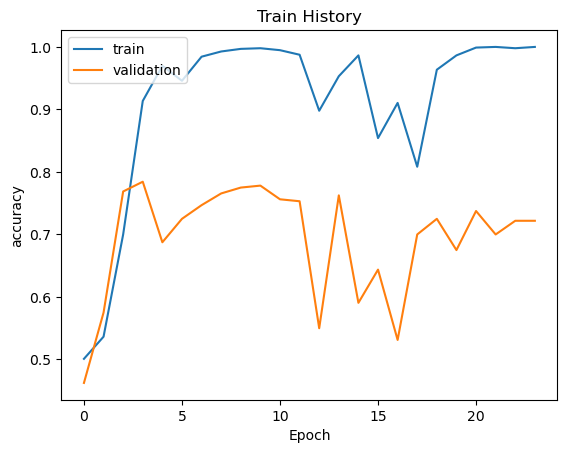

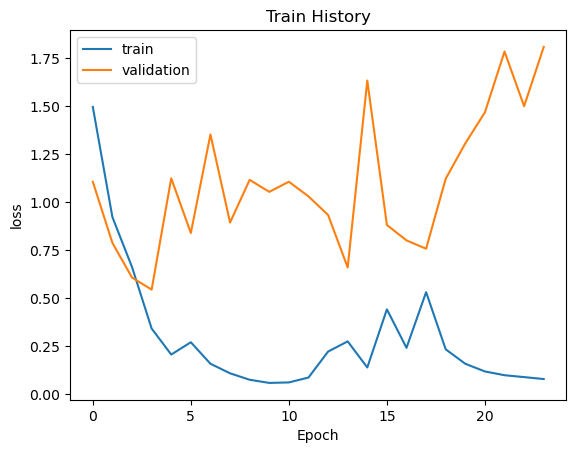

In [18]:
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
show_train_history(history_c,'accuracy','val_accuracy')
show_train_history(history_c,'loss','val_loss')

# measure accuracy and other measurement using validation set

In [19]:
from sklearn.metrics import classification_report


y_pred = np.round(cnn_model.predict(x_val).ravel())

print (classification_report(y_val, y_pred))


10/10 [==============================] - 1s 24ms/step
              precision    recall  f1-score   support

           0       0.74      0.72      0.73       172
           1       0.69      0.71      0.70       148

    accuracy                           0.72       320
   macro avg       0.71      0.72      0.71       320
weighted avg       0.72      0.72      0.72       320



In [20]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_val,y_pred))

0.715625


In [21]:
y_pred_label = []
for i in y_pred:
    if i == 1:
        y_pred_label.append("truthful")
    else:
        y_pred_label.append("deceptive")

        

# y_pred_label

In [22]:
y_val_label = []
for i in y_val:
    if i == 1:
        y_val_label.append("truthful")
    else:
        y_val_label.append("deceptive")


# y_test_label

In [23]:
def num_decep_truth(pred):
    num_deceptive = 0
    num_truthful = 0

    for i in pred:
        if i == 'deceptive':
            num_deceptive+=1
        elif i == 'truthful':
            num_truthful+=1
    return {"num_deceptive":num_deceptive,"num_truthful":num_truthful}

In [24]:
# sentences_val

In [25]:
predict_val = pd.DataFrame({'val':sentences_val, 'Pred':y_pred_label, 'True_label':y_val_label}, columns=['val','Pred','True_label'])
predict_val['result'] = np.where(predict_val['Pred']==predict_val['True_label'], 1, 0)
# results.sort_values(by='result').head(20)


predict_val.sort_values(by='result')

,val,Pred,True_label,result
0,overall the hotel is beautiful the service was great all the employees were friendly and always willing to help my room on the north end had a great view of the city and the chicago river the bed and big fluffy pillows were very comfortable and relaxing the only downfalls were parking and the fitness room parking was a little on the pricey side and not exactly as close to the hotel as one would think it should be the hotel itself is huge with over rooms so you may feel like your getting your daily exercise in just walking from your room to the fitness center depending on where your room is located,truthful,deceptive,0
194,this hotel was perfect for our girls getaway the decor is fun refreshing loved the roof top bar every staff member was friendly always smiling the location is perfect for michigan ave shopping the beach dinner and night life it was a mile or two from millenium station the concierge recommended a couple places to hang out after dinner and added our names to the guest list i m sure they do it all the time but still a nice gesture,deceptive,truthful,0
193,we really enjoyed our stay it is a beautiful hotel and the entire staff is helpful and polite they had great suggestions on where to eat what to do etc we were within walking distance of many great chicago locations like the navy pier and art institute the rooms were clean and the beds comfortable i would recommend this hotel to anyone looking for a great home away from home in chicago,truthful,deceptive,0
187,i recently stayed at the palmer house hilton on a business trip to chicago i will do my best to make sure that future employees of my company do i have to stay here when the reservation was made an early check in was arranged due to travel arrangements my travel companion and i were to get to the city in the early hours of the morning we had arranged an early check in without having to pay for the night before there was no fuss raised when we agreed on this and so we assumed it would be fine when we got there however there were no rooms available for us for hours and they refused to keep our bags we were forced to change clothes and wash up in the public restrooms of the office building where our first meeting took place and cart our bags around with us they offered insincere apologies and didn t offer to comp us anything for the inconvenience the rest of the stay one night was nothing to praise i guess not having bugs would count as positive i would definitely never recommend that anyone stay here,truthful,deceptive,0
182,i had a great time here it is centerally located in chicago so walking around is so easy and pleasent the staff was amazing and very helpful parking was a bit steep but to be expected the room was very nice and the bed and linens were very confortable the yoga mat rental was wonderful as well wonderful and relaxing experience overall,deceptive,truthful,0
...,...,...,...,...
160,the omni chicago is hands down the best hotel in my opinion in the chicago area i am a neat freak but here you need not worry about cleanliness as they are the best at keeping the rooms tidy our check in was easy and fast and the staff at the hotel was very courteous and friendly i forgot my hair dryer but thankfully one of the many perks at this hotel they provide one for you in your room that s a small benefit compared to the lucious pool and dreamy massages they offer i have never had a massage like that before my favortie thing about the omni is the high speed wireless internet that is available to all guests i am able to do my work online in all areas of the hotel which saved me a lot of time as i was not at my office but still had a lot of work to get done i also loved the tv they provide in the room a big plasma with a beautiful crisp picture i don t even have that at home needless to say i spent almost all night lounging in the comfortable bed watching movies only to fall asleep and wake up to the newspaper delivered to my ho

In [26]:
wrong = 0
right = 0
for i in predict_val['result']:
    
    if i == 0:
        wrong+=1
    else:
        right+=1

print("The wrong guess is : ", wrong)
print("The right guess is: ", right)

The wrong guess is :  91
The right guess is:  229


In [27]:
print('Training loss \t', history_c.history['loss'][-1]*100)
print('Training accuracy ',  history_c.history['accuracy'][-1]*100)
print('Validation loss ', history_c.history['val_loss'][-1]*100)
print('Validation accuracy ',  history_c.history['val_accuracy'][-1]*100)

Training loss 	 7.72002711892128
Training accuracy  100.0
Validation loss  180.7422399520874
Validation accuracy  72.1875011920929


In [28]:
new_text = "I love this hotel. The staff is very friendly. I don't think there is any places as good as this"
new_sequence = tokenizer.texts_to_sequences([new_text])
new_data = pad_sequences(new_sequence, maxlen=maxlen)
prediction = cnn_model.predict(new_data)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 439ms/step
0.002458634
deceptive


In [29]:
new_text = "During my holiday at Bali, I stayed at Hilton hotel. We arrived there at 12am. There was no staff. No one is coming to help us. We have to carry our luggae to the room. There was monkey everywhere. My girlfriend is afraid of monkey and she's not coming to the room. She has a terrible experience. So am I. If only we can get rid of the monkey and the staff is helpful, that would be nice. Why? because the place itself is big and the room is comfortable. The environment is good except the monkey. The service is kind of not so good."
new_sequence = tokenizer.texts_to_sequences([new_text])
new_data = pad_sequences(new_sequence, maxlen=maxlen)
prediction = cnn_model.predict(new_data)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 25ms/step
0.00701586
deceptive


In [30]:
new_text = "We planned to stay for 5 nights on a family trip. I booked this hotel because of the expected value for a suite as well as the free breakfast - get a quick bite, then head out for the day to do normal tourist stuff. Well, our stay here lasted 1 night and we quickly, and thankfully, switched to a different hotel for our last 4 nights. The room was dirty. When we opened the sofabed, the sheets were filthy and there was a mess of dirt and crumbs that fell out. Ridiculous considering this is a suite hotel where the sofabeds are likely used, and theoretically cleaned, a lot. Extra blankets were also dirty and bathrooms weren't much better. Temperature control in the room was imprecise - minor inconvenience but without clean blankets on our only night, it made for a cold stay. If you like to eat for free (they have free breakfasts and dinner on certain nights) and don't care to eat the great food Chicago has to offer, I guess some may find this place tolerable. But we found the buffet no better than average and felt like we were at a Golden Corral. The only thing this hotel really has going for it is location but there are other options in this area (we switched to The James and had a great experience). I couldn't be paid to stay here again. I'm shocked by the high overall rating given our experience."
new_sequence = tokenizer.texts_to_sequences([new_text])
new_data = pad_sequences(new_sequence, maxlen=maxlen)
prediction = cnn_model.predict(new_data)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 24ms/step
0.27377862
deceptive


In [31]:
new_text = "I had to do a little research on the Hilton brand because it's not one that I was familiar with. I wanted to know what this hotel chain's reputation was, so I did a little research online and found out that it's pretty well-known as a chain that people book into for their business trips and vacations. I also found out that this hotel chain is pretty well-reviewed by people who have stayed in their hotels."
new_sequence = tokenizer.texts_to_sequences([new_text])
new_data = pad_sequences(new_sequence, maxlen=maxlen)
prediction = cnn_model.predict(new_data)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 24ms/step
0.0069725034
deceptive


In [32]:
y_pred = np.round(cnn_model.predict(x_test).ravel())

10/10 [==============================] - 0s 24ms/step


# Test the created model on test data and see it performance 

In [33]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test,y_pred))

0.728125


In [34]:
from sklearn.model_selection import KFold
import numpy as np

k = 5
kf = KFold(n_splits=k)
scores = []

for train_index, test_index in kf.split(sentences):
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
    
    cnn_model.fit(x_train, y_train, epochs=5)
    scores.append(cnn_model.evaluate(x_test, y_test))

print("Avg. cross-val accuracy:", np.mean(scores))


Epoch 1/5
30/30 [==============================] - 4s 120ms/step - loss: 0.0612 - accuracy: 0.9990
Epoch 2/5
30/30 [==============================] - 4s 120ms/step - loss: 0.0472 - accuracy: 1.0000
Epoch 3/5
30/30 [==============================] - 4s 120ms/step - loss: 0.0380 - accuracy: 1.0000
Epoch 4/5
30/30 [==============================] - 4s 120ms/step - loss: 0.0325 - accuracy: 1.0000
Epoch 5/5
10/10 [==============================] - 0s 23ms/step - loss: 1.3669 - accuracy: 0.7094
Epoch 1/5
30/30 [==============================] - 4s 118ms/step - loss: 0.0231 - accuracy: 1.0000
Epoch 2/5
30/30 [==============================] - 4s 120ms/step - loss: 0.0198 - accuracy: 1.0000
Epoch 3/5
30/30 [==============================] - 4s 120ms/step - loss: 0.0184 - accuracy: 1.0000
Epoch 4/5
30/30 [==============================] - 4s 121ms/step - loss: 0.0160 - accuracy: 1.0000
Epoch 5/5
10/10 [==============================] - 0s 23ms/step - loss: 1.7395 - accuracy: 0.6938
Epoch 1/5
30

In [35]:
from sklearn.metrics import classification_report

print (classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.71      0.76      0.73       157
           1       0.75      0.70      0.72       163

    accuracy                           0.73       320
   macro avg       0.73      0.73      0.73       320
weighted avg       0.73      0.73      0.73       320



In [36]:
y_pred_label = []
for i in y_pred:
    if i == 1:
        y_pred_label.append("truthful")
    else:
        y_pred_label.append("deceptive")


# y_pred_label

In [37]:
y_test_label = []
for i in y_test:
    if i == 1:
        y_test_label.append("truthful")
    else:
        y_test_label.append("deceptive")


# y_test_label

In [38]:
predict_test = pd.DataFrame({'Test':sentences_test, 'Pred':y_pred_label, 'True_label':y_test_label}, columns=['Test','Pred','True_label'])
predict_test['result'] = np.where(predict_test['Pred']==predict_test['True_label'], 1, 0)
# results.sort_values(by='result').head(20)


predict_test.sort_values(by='result')

,Test,Pred,True_label,result
159,recently i traveled to chicago for a business conference and was lucky enough to stay at the hyatt regency chicago the whole experience was wonderful the room was spacious and beautiful and the bed was so comfortable that i had no problem falling asleep as i normally do at other hotels the staff were polite and courteous and after a delicious breakfast in the restaurant i went to my conference with a smile on my face,truthful,deceptive,0
237,what a wonderful experience super great helpful friendly staff angie at the front desk made sure my husbands birthday would be great our room was beautiful angie suggested we go to sullivans for dinner perfect choice make the reservation for us best seat in the house and a special dessert wow above and beyond what any other hotel or staff has done for us before looking forward to staying there again again thanks again,deceptive,truthful,0
238,arrived at only to find that sleep was not in my future because of the dance club connected to the hotel if you party and stay out all night anyway this hotel would be fine but don t plan to get any rest if the club is open front desk lady was extremely rude to people calling in to inquire about the hotel while i was checking in she was fine with me and gave me a corner room but sure wouldn t want to be on her bad side,deceptive,truthful,0
109,i recently stayed at the amalfi hotel in chicago although i visit this fun city quite often i was somewhat disappointed with the service and noise in a hotel that is called luxury boutique to begin with our experience designer was somewhat put offish and cool she did not really have a grasp of all the wonderful things to do in chicago although she did look up some attractions it seems like she may have recently arrived from la as far as the room it was indeed luxury and had nice lighting and decoration however the noise from the adjoining room was unbelievable and kept us up all night most likely the walls are very thin and construction is not the greatest who wants to hear the neighbors especially when they are honeymooners or whatever so we probably will not stay there again the location is great the cocktails fine the luxury is there but other than that it is the pits weary traveler san francisco,truthful,deceptive,0
240,we stayed at the hard rock for one night to do some intense day after thanksgiving shopping it really is a great hotel the rooms are really cool and we were just in the basic one the bed is extremely comfortable with the softest sheets and great pillows the technology in the room is great they have nice upscale tolietries in the bathrooms for a very modern room it is still comfortable and homey the location is perfect for getting wherever you want to go the staff were very nice and helpful the bar is really funky with an interesting martini menu one of the best hotels i have stayed at in chicago really enjoyed it and would highly recommend,deceptive,truthful,0
...,...,...,...,...
128,the amalfi hotel has a beautiful website and interior decorating but that s about it when my wife and i got here we were given keys to a room that had not even been cleaned the internet access promised on the hotel s website was down so i couldn t catch up on any of the business i had intended to do and my wife thought that the dark design details in the room made her feel claustrophobic like she was sleeping inside a salvador dali painting all in all this hotel was not worth the money especially since we spent most of our time enjoying the city something more casual and comfortable would have been better and it would probably have been cleaner too,deceptive,deceptive,1
129,we arrived at the omni on september for a day stay i took ill when i left the plane after travelling from manchester so i saw more of the room than i anticipated i couldn t go out for days the room was spacious and clean the bed was extremely comfortable the bathroom was large and very clean what more could you

In [39]:
wrong = 0
right = 0
for i in predict_test['result']:
    
    if i == 0:
        wrong+=1
    else:
        right+=1

print("The wrong guess is : ", wrong)
print("The right guess is: ", right)
    


        

The wrong guess is :  87
The right guess is:  233


In [40]:
num_decep_truth(y_pred_label)

{'num_deceptive': 168, 'num_truthful': 152}

In [41]:
num_decep_truth(y_test_label)

{'num_deceptive': 157, 'num_truthful': 163}

In [42]:
pkl = open('model2_22.pkl', 'rb');
clf = pickle.load(pkl);

new_text = "During my holiday at Bali, I stayed at Hilton hotel. We arrived there at 12am. There was no staff. No one is coming to help us. We have to carry our luggae to the room. There was monkey everywhere. My girlfriend is afraid of monkey and she's not coming to the room. She has a terrible experience. So am I. If only we can get rid of the monkey and the staff is helpful, that would be nice. Why? because the place itself is big and the room is comfortable. The environment is good except the monkey. The service is kind of not so good."
new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
prediction_label = np.round(prediction[0][0])
print(prediction_label)
print("truthful" if prediction_label==1 else "deceptive")



Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-04-10 15:11:48         3837
metadata.json                                  2023-04-10 15:11:48           64
variables.h5                                   2023-04-10 15:11:48     39398880
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......conv1d
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......embedding
.........vars
............0
......input_layer
.........vars
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
......max_pooling1d
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.......

In [43]:
new_text = "We planned to stay for 5 nights on a family trip. I booked this hotel because of the expected value for a suite as well as the free breakfast - get a quick bite, then head out for the day to do normal tourist stuff. Well, our stay here lasted 1 night and we quickly, and thankfully, switched to a different hotel for our last 4 nights. The room was dirty. When we opened the sofabed, the sheets were filthy and there was a mess of dirt and crumbs that fell out. Ridiculous considering this is a suite hotel where the sofabeds are likely used, and theoretically cleaned, a lot. Extra blankets were also dirty and bathrooms weren't much better. Temperature control in the room was imprecise - minor inconvenience but without clean blankets on our only night, it made for a cold stay. If you like to eat for free (they have free breakfasts and dinner on certain nights) and don't care to eat the great food Chicago has to offer, I guess some may find this place tolerable. But we found the buffet no better than average and felt like we were at a Golden Corral. The only thing this hotel really has going for it is location but there are other options in this area (we switched to The James and had a great experience). I couldn't be paid to stay here again. I'm shocked by the high overall rating given our experience."
new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 24ms/step
[[0.27377862]]
0.27377862
deceptive


# Testing using Expedia Dataset

In [44]:
new_text = "I booked flights through expedia.co.uk I had to cancel due to a medical emergency. One airline (outbound) refunded tax directly. The other airline (return) said I was eligible for a tax refund, but that I had to go through expedia as the agent. Expedia claims that the tax is non-refundable, as the flights are non-refundable. Airlines do not pay tax for seats that have not been used. So who is profiting from the un-used tax? My guess is Expedia since the airline was happy to refund."
new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 24ms/step
[[0.99471104]]
0.99471104
truthful


In [45]:
new_text = "I booked a hotel stay with 15 days parking package and upon checking in at LGW hotel was told that they had no record of the number of days free parking. Expedia didn’t help at all, and even though my confirmation stated ‘free parking’ it didn’t say ‘15 days free parking’ and so Expedia say that my parking is all due to be paid myself for 15 days, despite me booking the specific package for £172. I won’t be using these muppets ever again, I’ve had to fork out parking to the hotel also. Not a happy Chappy. Avoid Expedia park and stay packages like the plague !!"
new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 24ms/step
[[0.9942592]]
0.9942592
truthful


In [46]:
new_text = "This food is amazing!!!!"
new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 23ms/step
[[0.00180337]]
0.001803375
deceptive


In [47]:
new_text = "This company is awful, tickets are put up only for them to take your money as a pending transaction and tell you it is because they no longer have seats available or the prices have changed... only for you to see two weeks later that the same flight is being advertised for the same price. I now have to wait for my money to come back into my account before I can book my flight elsewhere."
new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 24ms/step
[[0.9708336]]
0.9708336
truthful


In [48]:
new_text = "I use expedia a few times a year to book trips. This year in Prague one of our booked trips was cancelled by the provider, we turned up and they sent us away saying it was cancelled. After going backwards and forwards with expedia they will not issue me with a refund as the provider of the show will not respond to them. Viator reviews say that this show has not existed for several years, why is it still being sold!! Its an absolute con and expedia are helping them, I am totally disgusted and will not book with them again."
new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 23ms/step
[[0.99417657]]
0.99417657
truthful


In [49]:
new_text = "I booked with expedia long time ago. The experience was horrible. Arrived to the Prague airport early in the morning just to hear that there is no space in the plane, after some very worrying moments they said there is a space. Got in to the plane then the sit number i have been given was given to someone else so they told me that i can sit to somewhere else, guess what next.. the owner of that seat appeared also.. on and on… i was happy as i was in the plane but the experience was good enough not to book with this company ever again"
new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 24ms/step
[[0.99230736]]
0.99230736
truthful


In [50]:
new_text = "Kutchenhaus, Hythe, Kent. 5 Stars for this kitchen shop, specialising in high quality German craftsmanship. We were hugely impressed with the courteous and well-informed advice we were given by Ben and his expertise in describing the different possibilities we could choose from my wife and I recommend this shop 100%."

new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 23ms/step
[[0.00266192]]
0.0026619204
deceptive


In [51]:
new_text = "Great staff at Quart Pot. Bar staff very friendly - Lisa,Scarlett and Grace. Good food too"

new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 23ms/step
[[0.00474278]]
0.004742777
deceptive


In [52]:
# swap postive to negative. deceive 
# correct grammar truthful. If incorrect grammar, deceptive.

# one generated review by computer is considered truthful but with a very low score.
# another generated review by computer is considered deceptive with very low score.

# when it talk about something general such as information that can be found on internet, it is deceptive.
# when it talks about some experience that is not available on internet, but a make up information. It tends to be
# truthful but with very low score.

# If there is any explicit information, it tends to be truthful although those info can be made up.

# If the experience were negative and with information, tends to be truthful.

# negative comment with enough info tends to be truthful.

# Baseless positive comment, results in deceptive.

# Most complaint with some realistic event is considered truthful.

# positive comment can be truthful but with a lower score. Context has to be realistic as well, not just vague praise

# psotive comment with a lot of supporting information can also be truthful.

# both positve and negative comment comes together to be neutral, also truthful. 

# all the review from yelp is considered truthful, either negative or positive.

# when location is involved, it tends to say truthful. Although the place does not actually exists because the additional information adds up.


# when a lot of information is given, it sounds truthful.

# when short comment and incorrect use of grammar. Deceptive.

# detail information can provide evidence as review being truthful

# sound like a conversation, negative with info is considered deceptive.

# if it makes complaint about one product, and promote another. Also deceptive

#  if it looks too properly, like somebody wrote a proper paragraph rather than just review, also deceptive.

# if it is positive experience, but they express as a proper paragraph for that experience, also deceptive.

#  if it looks like it praise the product a lot, but the way they describe it is like a robot, deceptive.

# short review is likely to be deceptive, if truthful, the score is low. 

#  just praise with little detail will be classify as deceptive.

#  if you use third person a lot, it will be deceptive, even if truthful, with lower score.

# can conclude that a lot of negative experience is considered truthful. If short review but sound very negative, will be
# truthful but with low score.

# Some negative review, although with detail, if talk in third person, is also likely to be deceptive.

# if the way of writing review is kind of informal, considered truthful.

# even though negative, if the way they write is too formal. Ex. without sign !! or ##. likely to be considered deceptive
# because it is highly generated by PC.

# if they mentioned the name of specific company in purpose to try to bring it down, also deceptive.

# sth is written in third person and with email is also considered deceptive.

# Too extremely negative will likely be deceptive.

# if negative but with reasonable detail and neutral point, truthful.

# Extreme negative opinion is likley to result in deceptive. if truthful, with low score. 

# negative review is truthful only when provided lots of detail and try to reason instead of try to destory one brand.

# it cannot distinguish between some fact. Considered both as deceptive. 









In [53]:
new_text = "Absolutely appalled by my 'stay' at Iris Hotel Llandudno, we were unable to even stay in the hotel room because of the horrible stench that was coming from the drains! The poor receptionist tried to clean it with some bleach, but the smell would simply not go away, the carpets were filthy the beds were dirty, there was mould and grime all up the walls. The manager was nowhere in sight and since leaving the property because we was unable to stay we contacted the hotel in regards to a refund 0 response 0 care and compassion at the fact that we were unable to even stay at the property! we just paid a substantial amount for what it was avoid like the plague!!"

new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 23ms/step
[[0.42739183]]
0.42739183
deceptive


In [54]:
new_text = "As a Business owner, TripAdvisor is by far the worst company out there.We have a average review on our page that is clearly ment for a Restaurant 2km from us. The review states they had Fillet Steak and Trout. We do not serve those dishes. As TripAdvisor to correct this and was told they are happy it's correct. They clearly Did Not look at my page and menu to confirm this.It's about time TripAdvisor was monitored or research disputes professionally.Diabolical Company."

new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 24ms/step
[[0.99186796]]
0.99186796
truthful


In [55]:
new_text = "When it comes to finding the perfect hotel for your travels, there are plenty of options to choose from. However, if you're looking for a hotel that offers a comfortable stay with a touch of sophistication, Hilton is the perfect choice.From the moment you step into the lobby, you'll be impressed by the elegant decor and welcoming atmosphere. The staff is friendly and helpful, ensuring that all your needs are met throughout your stay.The rooms themselves are spacious and well-appointed, with comfortable beds and plenty of amenities to make you feel right at home. Whether you're traveling for business or pleasure, you'll appreciate the desk and complimentary Wi-Fi that make it easy to stay connected while you're away.One of the standout features of this hotel is its location. Situated near Bali Airport, it offers easy access to all the city's top attractions, while still providing a quiet and peaceful retreat when you need to unwind.Overall, if you're looking for a hotel that combines style"

new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 23ms/step
[[0.00317408]]
0.003174084
deceptive


In [56]:
new_text = "If you're in the market for an exceptional hotel experience, you can't go wrong with Marriot. As a knowledgeable traveler, I'm always looking for accommodations that offer comfort, convenience, and additional amenities. The Marriot is abundantly equipped with all of these features and more.From the moment I arrived, I knew that I was in for an extraordinary experience. The hotel's location is ideal, situated in a convenient and centralized area that made exploring the community effortless. The lobby was welcoming and well-lit, ensuring a positive first impression. The staff was friendly, courteous, and accommodating, eager to help us make the most of our stay.The rooms at Marriot are fantastic, with plush bedding and beautiful decor that sets the mood for relaxation. With 24/7 service to Spa, pool, and skybar, we had everything we could need at our fingertips. Furthermore, the hotel went the extra mile by providing free dinner and free breakfast, which was a real treat."

new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 23ms/step
[[0.991946]]
0.991946
truthful


In [57]:
new_text = "When it comes to finding the perfect hotel for your travels, there are plenty of options to choose from. However, if you're looking for a hotel that offers a comfortable stay with a touch of sophistication, Hilton is the perfect choice. From the moment you step into the lobby, you'll be impressed by the elegant decor and welcoming atmosphere. The staff is friendly and helpful, ensuring that all your needs are met throughout your stay. The rooms themselves are spacious and well-appointed, with comfortable beds and plenty of amenities to make you feel right at home. Whether you're traveling for business or pleasure, you'll appreciate the desk and complimentary Wi-Fi that make it easy to stay connected while you're away.One of the standout features of this hotel is its location. Situated near Bali Airport, it offers easy access to all the city's top attractions, while still providing a quiet and peaceful retreat when you need to unwind."

new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 24ms/step
[[0.00311118]]
0.0031111802
deceptive


In [58]:
new_text = "AVOID After paying £200 / 40% deposit to Trip Adviser for holiday apartment it turned out property wasn't available at all. It took over 4 weeks, 20+ emails, & several phone calls repeatedly asking for return of deposit before they even started refund process and this despite having 1 message from property manager and 2 messages from T/A's own help centre stating that property not available. Help centre polite but totally useless. Overall, customer service absolutely pathetic."

new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 24ms/step
[[0.9825494]]
0.9825494
truthful


In [59]:
new_text = "I have found TripAdviser very useful when planning trips for its reviews. However it is failing in a very big way when it comes to booking tickets for events via its website.On 19/1/2020 I booked 4 Gold VIP seats for Skip the Line Pattaya Tiffany Cabaret show for 24/1/2020. The booking was confirmed and the money taken $160. It showed the Tour operator was YTS Holidays Co Ltd.Next day I received an email via TripAdviser saying there were no Gold VIP seats and I should pick ordinary VIP seats instead.I did not want to do this and complained that seats should not be sold if they did not have them.I received a further email via TripAdviser saying Gold VIP seats were not available, you can cancel and will receive a refund.21/1/2020 I cancelled but website showed refund = 0I then received an email from TripAdviser saying 'We have cancelled your booking but no refund as per our Terms and Conditions'.Both TripAdviser and YTS Holidays are refusing to reply to any further emails.I would strongly advise against making any bookings on the TripAdviser website. I consider I have been subjected to Fraud."

new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 24ms/step
[[0.99045205]]
0.99045205
truthful


In [60]:
new_text = "the worst company I have ever dealt with between them and their sister company hotwire.comthey have about ruined my vacation I have been billed 3 times for the same room and Air flight I have had numerous phone calls to both companies with very little help I am still waiting on a refund they tried to tell me if my credit card must have been stolen so the thief book the room next to mine on the same night I was there these people need to figure out how to run a business and actually give customer service"

new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 23ms/step
[[0.9927492]]
0.9927492
truthful


In [61]:
new_text = "1- Waited twice for over 20 minutes to reach an agent.2- Asked agent to give me information package allowance on flight booked, the agent ask me to call the airline to find it. Then he ask me to wait so he can call the airline (easy jet). kept me waiting for long time , I get fed up and hangup the call.3- When booking through Expedia Website, Expedia does not show that easyjet does not have 'Checked Package' Allowance like the rest of Airlines hence you discover later that you have to pay easyjet extra for each Checked in bag."

new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 24ms/step
[[0.99456865]]
0.99456865
truthful


In [62]:
new_text = "Sent me to an all inclusive trip to Occidental Grand Punta Cana. There was no electric or water the 1st night I was there from 11:30 pm to 2 pm the next day (14 hrs) it was the main generator that went out and has been going out on a daily bases. I tried to get moved to another hotel and they would not in less I called expedia, which I did on my cell phone as they would not let us use their phones. I was on the phone for half hour waiting to talk to a supervisor (after talking to 5 people) I finally got one and she promised to call me back after calling the hotel to get me out of there. That is the last I heard from them so I lived in hell for 5 days - no flushing toliets, no cleaning hands (even the cooks and servers) no showers for 14 hrs straight - you can imange the smell plus the food they served with dirty hands. The electric woud go on and off like that the whole 5 days. and guess what now they will not even give me my money back. DO NOT USE THEM THEY WILL TAKE YOUR MONEY AND SEND YOU TO HELL OR AND BY THE WAY THEY ARE STILL SELLING THIS PACKAGE AFTER KNOWING WHAT IS GOING ON."

new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 24ms/step
[[0.99133795]]
0.99133795
truthful


In [63]:
new_text = "Booked flight and hotel accommodation in San Francisco with Expedia. Everything went fine."

new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 24ms/step
[[0.00421217]]
0.0042121685
deceptive


In [64]:
new_text = "The Athena Hotel is in a surprisingly nice area, walkable in just a couple minutes to Paddington and the Underground, and a brisk walk to Hyde Park and Marble Arch.The value for location is quite good. But the hotel definitely comes across as budgetThe room we had was TINY. Our 4 person room had a double and two single beds. That took up essentially the whole room. We needed to push the bed aside slightly just to open the front door. The luggage filled spaces with beds so we had to pack away the chair and move the kettle and coffee/tea to a bedside table just so we could access it.We were okay with it but it felt like we were on top of each other and it was hard to keep the room tidy since there was just no room to do anything.The breakfast is limited and only available in a one-hour window, so we didn't pay for it and went for pastries and fruit or other nearby breakfasts nearby instead.On our final day we were looking forward to good showers before heading out on a long day of travel, but the water was ice cold. A bit of a letdown adding to it all, which really is what bumped my review down from a 3 to a 2."

new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 23ms/step
[[0.99401915]]
0.99401915
truthful


In [65]:
new_text = "This hotel has an excellent location, kind & gracious staff and comfortable beds, While most people come here with children, I would recommend it as a quiet place to stay on a budget"

new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 23ms/step
[[0.00235605]]
0.0023560522
deceptive


In [66]:
new_text = "Trigger warning : this is a long reviewAs an asian/american from california, first time UK traveller, this walking/train commuting is all new to me. I did alot of researching and review reading to make sure that i would choose the right hotel for my taste.I chose Athena:first for the location. It is VERY close to paddington station, which is kinda the main hub going to london's outskirts, heathrow express and also close to the the tubes ( did i say that correctly ). Also ALOT of restaurants, convenient store and laundry place is very close as well.Second reason is that most of the reviews i saw online was positive. My stay here felt like im their house guest. Room service is done everyday, fresh towels and very clean room. Breakfast is complimentary. My first day we went to durdle door and needed to bring snacks for the trip, the very nice lady from the kitchen let us borrow her lunchbox so we can bring the porridge while driving.. so sweet of her.Third reason is that the staff are all amazing and very friendly.Mario Jr, who helped us check in and settle our car parking ( we rented a car so we can just drive outside london for 3 days. Parking is $15 per day, book early coz its limited spots)Mo from night shift was also nice, funny guy as well.And for Meliha, she was very accomodating, friendly and helpful.For the rooms, its cute, small but cozy. Typical bed and breakfast. Bathroom is medium size, shower has a rainfall shower head and handheld so you can use both. maybe the only thing i didnt like is that the shower glass is only half of the shower area, so put like a towel on the floor so you wont slip when you get out of the shower area.They also have luggage storage which is very convenient if you're planning to go somewhere then come back.Overall, my stay at Athena was amazing. I felt at home.Thank you everyone and keep up the good work."

new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 24ms/step
[[0.99367243]]
0.99367243
truthful


In [67]:
new_text = "Cheap, clean and good location for catching buses and the Underground.However, room is very tiny with a single bed, tiny shower and tiny sink. Included English breakfast is canned fruit cocktail, cold baked beans and toast.  If you want to save money it's a good deal."

new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 24ms/step
[[0.48062646]]
0.48062646
deceptive


In [68]:
new_text = "The Athena Hotel is along London near Nottingham Station. It sit amongst a line of row houses that have almost all been converted into small hotels.The Athena is just around the corner from an entry into Paddington Underground. Also just a block away from busy Praed Street, which is full of shopping, eating and drinking oppurtunities.The staff is friendly, helpfull and efficient. Our room was a reasonable size with a large bathroom that included a full bath. The towls are fluffy and new. The bed is fairly comfortable and the room was stocked with 2 extra pillows and a blanket in the closet. Flat screen TV and phone in the room.The location is good, the price reasonable, the staff inviting and the rooms comfortable and clean....and a full English breakfast is included in the rate!"

new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 24ms/step
[[0.99426657]]
0.99426657
truthful


In [69]:
new_text = "This hotel is perfectly off the beaten path! We got a family room with bunk beds. The front desk staff was very kind and helpful! The full English breakfast and WiFi were the best accommodations! I would stay here again in a heart beat! Load of cafes within walking distance!"

new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 23ms/step
[[0.02803386]]
0.028033864
deceptive


In [70]:
new_text = "Horrible Room for the Price. My family and I checked into the Athena for a two night stay, and upon seeing the room immediately wanted to check out. The molding on the walls were cracked and peeling. The beds we requested were correct in number, however the covers were old and dingy, matching the curtains. Upon arrival, we also found out that they do not have air conditioning, which according to the receptionist they do not advertise ?? As a result, since it was London in July, we had to keep the windows open to let in the slightest bit of breeze. So immediately (since there were no screens) flies and insects began swarming into the room. So not only was it hot, we were being bitten by insects and couldn't sleep at all. The hotels right on a major street, so every few minutes a honking bus or taxi would drive by. And the best part?? They have a no exception refund policy. So after a poor breakfast of eggs and beans (like seriously, they only had an English breakfast and some cereal options) we checked out and found another hotel. I've contacted Expedia to see about getting a refund on their end but have received no word back. Definitely not a three star hotel, and should not be advertised on Expedia! Not a good experience at all"

new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 23ms/step
[[0.99420774]]
0.99420774
truthful


In [71]:
new_text = "Noisy, very  very expensive for a tiny service, employee desk unpleasant..... That's enough to go your way"

new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 24ms/step
[[0.00253657]]
0.0025365674
deceptive


In [72]:
new_text = "Customer service is terrible. They take days to work your issue as they don’t work weekends!! No one backs them up. Broke my foot and my host isn’t handicap accessible and won’t refund. Guess I’ll never go to Niagara Falls as Niagara Hospitality is below 1 rating. Horrible news experience ."

new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 24ms/step
[[0.00305651]]
0.003056509
deceptive


In [73]:
new_text = "Their customer service was awful. They are highly overpriced. Airbnb always sided with a rude and delusive host.They did not provide smoke detectors as they supposed after several Americans have died from carbon monoxide. They did not disclose the fact that a condo in Puerto Vallarta was exposed to a terrible noisy drum beat from nearby disco and that the toilette had a stinky smell due to bad pipes."

new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 24ms/step
[[0.00800722]]
0.008007224
deceptive


In [74]:
new_text = "Horrendous from start to finish. If things go wrong they just bury their heads in the sand and leave the guest to pick up the pieces. Nobody speaks or understands English either which means you're forever stuck in a loop of generic messages requesting the same information and nothing gets done. Will never use again!!!"

new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 24ms/step
[[0.59213144]]
0.59213144
truthful


In [75]:
new_text = "We have reservation on Airbnb 10 mins walk from where a terrorist attack took place in Turkey. I have contacted AIRBNB and the host and both refused to give me the refund.Travelling as a family with kids we have decided it will be risky to travel to and stay at a location where a terrorist attack took place.As per the terms and conditions of Airbnb, it claims terrorist attacks and country advisories as an event in which they would accept a refund for.As per one traveller who went on the news about cancelling a Airbnb booking due to terrorist attacks in Paris, he was refunded fully by Airbnb even though the host declined.I don’t understand why Airbnb didn’t equally refund us our reservation. I have recorded ZERO assistance from Airbnb. Which makes us think 5-10 times before choosing to book on here."

new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 24ms/step
[[0.9897115]]
0.9897115
truthful


In [76]:
new_text = "What a dreadful company AirBNB is. They knowingly allow hosts to provide misleading information.How can you have photos of a bathroom showing a bath but when you get there it hasn't got any taps or a plug!! Advertises a freezer which wasn't there.Their 'customer service' is an absolute joke. If you don't reply within 90 minutes they close the case. This happened to me at 11pm when I was asleep!"

new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 24ms/step
[[0.41941223]]
0.41941223
deceptive


In [77]:
new_text = "It’s interesting to read all these terrible reviews when I have experienced the same but as a host. All is fine until it goes wrong with a problematic guest and they didn’t want to know. Generic replies and not one of my questions answered."

new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 24ms/step
[[0.0052279]]
0.0052279043
deceptive


In [78]:
new_text = "France is in the United Kingdom"

new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 23ms/step
[[0.00174627]]
0.0017462699
deceptive


In [79]:
new_text = "France is not in the United Kingdom"

new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 23ms/step
[[0.00189809]]
0.0018980867
deceptive


In [80]:
new_text = "France is not in the United Kingdom"

new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 24ms/step
[[0.00189809]]
0.0018980867
deceptive


In [81]:
new_text = "Airbnb service fees and cleaning fees are ridiculous! Bad enough on price for stay plus tax. Try to book something nice for me and my boyfriend for a week in TN for my birthday and everything I would love to stay at is so damn expensive! I've never booked with airbnb before and would like to if prices weren't so ridiculous! People could still make $ even if the prices weren't so high!"

new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 24ms/step
[[0.4798213]]
0.4798213
deceptive


In [82]:
new_text = "I booked accommodation well in advance at a reasonable price. The host cancelled 24 hours before I was due to check in. Airbnb did nothing to assist me in getting an alternative accommodation at the last minute and I could have booked a hotel in the first place cheaper than what I ended up paying. I will be very reluctant to ever use their platform in the future."

new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 24ms/step
[[0.98265934]]
0.98265934
truthful


In [83]:
new_text = "Awful wanted personal information from us ..photo id .etc just to book .forget it went to booking.com instead .Airbnb lost 2 k still they won't care .awful stay away!!!"

new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 24ms/step
[[0.00714236]]
0.0071423566
deceptive


In [84]:
new_text = "My family booked a stay a week or so before our trip. We had to cancel a day before because several members of the party including myself became ill with Covid. I contacted the host and her suggestion was to book for another date. I contacted both Airbnb and the host for assistance with a partial refund and after several days of back and forth they were not willing to provide any sort of refund because Covid is not a thing anymore. I understood the host's cancelation policy however I did not imagine we would become sick. Neither the Host or Airbnb were willing to provide any sort of refund. After leaving a review of my experience it was removed because I did not complete my stay. I explained that I only listed my experience and it was a simple beware to those who are looking to book that the cancellation policy is strict. Airbnb is in the business of protecting their hosts they are truly in no way interested in their guests once payment is received."

new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 24ms/step
[[0.9939223]]
0.9939223
truthful


In [85]:
new_text = "what a useless site. once you are super-blocked you can pull our your clock and random access memory it against brian and valeriya (and their 'friends')."

new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 24ms/step
[[0.00217084]]
0.002170837
deceptive


In [86]:
new_text = "What a dreadful company AirBNB is. They knowingly allow hosts to provide misleading information.How can you have photos of a bathroom showing a bath but when you get there it hasn't got any taps or a plug!! Advertises a freezer which wasn't there.Their 'customer service' is an absolute joke. If you don't reply within 90 minutes they close the case. This happened to me at 11pm when I was asleep!"

new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 24ms/step
[[0.41941223]]
0.41941223
deceptive


In [87]:
new_text = "My wife and I are extremely well traveled, and have stayed at well over 100 airbnbs. Contrary to what others have posted here, we've experienced A+ properties, nice hosts, well-located properties, and accurate information. We read reviews VERY carefully. If a landlord has multiple properties, we read the reviews of other properties. We use google street view to check out the neighborhood. We ONLY stay at places that have A+ reviews. We ONLY communicate via Airbnb's platform. The only time that we had a minor issue, Airbnb responded immediately and de-platformed the host. Wow!"

new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 23ms/step
[[0.99441874]]
0.99441874
truthful


In [88]:
new_text = "I just lost $250 because of Airbnb problematic policy.I booked a place, it was never mentioned anything about noise around. There is a mosque producing high volume prayers from its speakers five times a day starting at 4:00 a.m.After I booked it I saw reviews on different websites like booking.com saying there is a loud noise that is affecting the hotel and making it hard to sleep and enjoy a quiet vacation.According to Airbnb policy, noise problems are a minor issue!! And that's the reason I didn't get a full refund only half.I'm asking myself how can it be that when you're going into a vacation that a noise problem would be a minor issue?I was scheduled to be in this place for 2 weeks enjoying a peaceful surrounding. I cannot imagine myself enjoying while there is unpleasant noise around me.From now on I will try to avoid using Airbnb services and turn to alternatives."

new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 23ms/step
[[0.92129105]]
0.92129105
truthful


In [89]:
new_text="Hello"
new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 24ms/step
[[0.00173482]]
0.001734819
deceptive


In [90]:
new_text="Was informed I had two days remaining to submit a review. When I tried, I was informed the 1:00pm time had expired, even thoug a time was not noted in the reminder email. 20 wasted minutes later with a 'Support' bot changed nothing, except getting condescending msgs that I need to review the policy again. Which addressed NOTHING about the arbitrary time cut-off."
new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 24ms/step
[[0.9676067]]
0.9676067
truthful


In [91]:
new_text="Be very very careful with Airbnb, I’ve only had issues from both host and guest. They won’t even issue an invoice that notes the full address of the property you stay at, they also won’t issue a letter that outlines the address. They spin a total internal jargon message saying they operate from Ireland and don’t have to comply with other countries consumer laws. They also refuse to provide the next level of complaint/Group Customer Relations to resolve a complaint. Tread very carefully.Hi xxx,Thank you for your reply. understand your request and where you are coming from.To sum up, we are not able to issue a receipt or letter other than the receipts or invoice on our website. Nevertheless, the Australian Taxation Office (ATO) does not issue Airbnb Ireland UC with an ABN, nor is it permitted to issue tax invoices for the services provided to Australian consumers.We seek your understanding that we must respectfully disengage from further correspondence as we are unable to provide further support for this case.If you'd like to give us feedback on this issue, our policies or your experience, you can do so at: xxxThank you.Best Regards,Brianna"
new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 24ms/step
[[0.67809075]]
0.67809075
truthful


In [92]:
new_text="I had an unbelievably frustrating experience with customer service. They closed my cases without even giving me the chance to respond! I can't believe the arrogance. Unfortunately, this seems to be a common theme with customer service across Airbnb. Even when guests damage property, they often don't take appropriate action they won't even allow bad reviews against irresponsible guests.-They charge hosts and guests too much fees.-Garbage customer service for hosts-No refund or compensation for destroyed property!! Aircover insurance my a**.-They don't allow bad reviews against guest so other hosts won't even know about it......Go with booking.com much more mature and professional customer service you can actually them and they wil call you."
new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 24ms/step
[[0.9941481]]
0.9941481
truthful


In [93]:
new_text="They are total garbage. The host has the right to unexpectedly cancel, but their cancellation policy severely penalizes the tenant. I won't ever use this business again. They refuse to assist you or step in if there is a problem and instead conceal behind their Terms and Conditions. Do not use them, they're only there to service themselves and to steal your money. Signup with F🅾️r*tune~~Gr🅾️up to make a much more informed choice. They offer the most lucrative investment service available, and withdrawal is quick and simple."
new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 24ms/step
[[0.40362826]]
0.40362826
deceptive


In [94]:
new_text="I have been unfairly treated. My reservation was cancelled by Airbnb just hours before I had to move in with my family and unable to book another place for 10 days !! We were left alone , with no shelter on a winter storm. Airbnb is definitely on the Host side , not on the guest side."
new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 24ms/step
[[0.02095482]]
0.020954818
deceptive


In [95]:
new_text="Terrible! The software if full of bugs. The system is unstable & cumbersome to use. Configurations made by the host are either not recorded or changed without the host's knowledge. Some information apears sometimes and other time does not. Messages disappear from the message inbox (essential to communicate with guests) without a reason never to be found again. Support just have no solutions. All they can do is apologize. I really don't understand how they can be so successful!"
new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 24ms/step
[[0.9893743]]
0.9893743
truthful


In [96]:
new_text="I booked an airbnb in Helsinki for a month. I arrived to a live building site - scaffolding covering every facade of the building. I was awoken each morning at 8.30am by drilling/hammering which continued sporadically throughout the day. When I complained to Airbnb,the host quickly added a picture with the scaffolding to the listing. She refused even a partial refund and denied noise despite me sending video proof of the noise to airbnb. Airbnb sided with her and said I wasn´t cover by aircover - although aircover states if the property is not as expected you are fully covered.Additionally, one morning, I heard male voices outside the apartment and suddenly someone put a key in the door and tried to come into the apartment. I always use the safety chain so the door slammed against the chain and they couldn’t get in. I was terrified. There was 3 men at the door saying they had to enter the apartment to check repairs. I did not let them in. I was very shaken up after this.The host said it was the housing authority who have a key to the apartment.After all this, airbnb are refusing to publish my review on the hosts listing without reason as to why. They block negative reviews, side with hosts and ´Aircover´ is just a bs marketing scam which doesn´t cover you for anything."
new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 24ms/step
[[0.70070523]]
0.70070523
truthful


In [97]:
new_text="I booked an airbnb in Helsinki for a month. I arrived to a live building site - scaffolding covering every facade of the building. I was awoken each morning at 8.30am by drilling/hammering which continued sporadically throughout the day. When I complained to Airbnb,the host quickly added a picture with the scaffolding to the listing. She refused even a partial refund and denied noise despite me sending video proof of the noise to airbnb. Airbnb sided with her and said I wasn´t cover by aircover - although aircover states if the property is not as expected you are fully covered.Additionally, one morning, I heard male voices outside the apartment and suddenly someone put a key in the door and tried to come into the apartment. I always use the safety chain so the door slammed against the chain and they couldn’t get in. I was terrified. There was 3 men at the door saying they had to enter the apartment to check repairs. I did not let them in. I was very shaken up after this.The host said it was the housing authority who have a key to the apartment.After all this, airbnb are refusing to publish my review on the hosts listing without reason as to why. They block negative reviews, side with hosts and ´Aircover´ is just a bs marketing scam which doesn´t cover you for anything."
new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")

1/1 [==============================] - 0s 23ms/step
[[0.70070523]]
0.70070523
truthful


# Test with unseen data from different distribution

In [98]:
new_text = "Love this!  Well made, sturdy, and very comfortable.  I love it!Very pretty"

new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")
# right

1/1 [==============================] - 0s 24ms/step
[[0.00199364]]
0.0019936422
deceptive


In [99]:
new_text = "What can you say--- cheap and it works as intended."

new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")
# right

1/1 [==============================] - 0s 24ms/step
[[0.00302471]]
0.0030247073
deceptive


In [100]:
new_text = "Really ruff under your feet, it feels very sturdy. I will keep my feet in the chair"

new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")
# right

1/1 [==============================] - 0s 24ms/step
[[0.0059361]]
0.005936104
deceptive


In [101]:
new_text = "Order to place special photos on the wall.  We've had it for a couple of weeks and"

new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")
# right

1/1 [==============================] - 0s 23ms/step
[[0.00194282]]
0.001942819
deceptive


In [102]:
new_text = "excellent product if you are a side sleeper this is perfect"

new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")
# wrong

1/1 [==============================] - 0s 24ms/step
[[0.00236567]]
0.002365667
deceptive


In [103]:
new_text = "Great product. Arrived on time and matched my shower curtain perfectly."

new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")
# wrong

1/1 [==============================] - 0s 23ms/step
[[0.00209868]]
0.0020986812
deceptive


In [104]:
new_text = "Perfection. Beyond easy to use, minimal effort, fast and perfect froth."

new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
print(prediction[0][0])
prediction_label = np.round(prediction[0][0])
print("truthful" if prediction_label==1 else "deceptive")
# right

1/1 [==============================] - 0s 24ms/step
[[0.00324077]]
0.0032407749
deceptive


In [105]:
df_test = pd.read_csv('../FakeReviewDataset.csv')
df_test

,category,rating,label,text_
0,Home_and_Kitchen_5,5,deceptive,"Love this! Well made, sturdy, and very comfortable. I love it!Very pretty"
1,Home_and_Kitchen_5,5,deceptive,"love it, a great upgrade from the original. I've had mine for a couple of years"
2,Home_and_Kitchen_5,5,deceptive,This pillow saved my back. I love the look and feel of this pillow.
3,Home_and_Kitchen_5,1,deceptive,"Missing information on how to use it, but it is a great product for the price! I"
4,Home_and_Kitchen_5,5,deceptive,Very nice set. Good quality. We have had the set for two months now and have not been
...,...,...,...,...
40427,Clothing_Shoes_and_Jewelry_5,4,truthful,"I had read some reviews saying that this bra ran small and so I ordered TWO band AND cup sizes UP and it was still too small! Definitely along the lines of a sports bra squish effect. The sides do come up high. Glamorise is one the best brands for bras, so I'm very surprised with this one. The front close idea appealed to me, but look carefully, there are 7 (yes, seven) clasps to do up. What a pain. I think if I had ordered 3 sizes up it might be ok. I won't return it as I'm losing weight, so it might fit better down the road. Will update review at that time. If you want a bra that doesn't let you jiggle at all without it being a minimizer and/or without wires, this would be good.\n\nUPDATE: After very recent gallbladder surgery that left me with a highly tender incision site, I found I couldn't wear any of my regular bras. I had ordered this one hoping I might be able to tolerate it. Initially, because it was so tight, I couldn't tolerate this one either. As I slowly healed, I kept trying the bra. Due to its elastic nature I was able to adjust this for comfort more than the others. After about two weeks, much to my amazement, I found the bra had lost its initial snugness and was in fact VERY comfortable! 5 weeks after surgery and this is still the only bra I can tolerate. The number of clasps in the front turned out to be a bonus as well, because I could choose to leave the bottom clasps undone, adding to the comfort level. I am still of the opinion that it runs too snug and I'm glad I ordered up.\n\nTake the time to break the bra in! All bras have a break-in period (in my opinion), and this one is no different. I'm actually quite happy with it now."
40428,Clothing_Shoes_and_Jewelry_5,5,deceptive,"I wasn't sure exactly what it would be. It is a little large for my small size, but I think it is a nice fit. The fabric is a nice thin material, but it is a little thin in the legs. I wish it was thicker. The material is soft and comfortable. I will keep it. I ordered a half size up and it fits great. I wear a 9 1/2. I like that the strap is longer than the waistband, which is nice. I am 5'5"" and the size 6 fits great. I am a medium. The bra is too short. It is a little narrow for me, but I think it would be a nice addition to my wardrobe. I will be buying another one in different colors. I have a small tummy and I ordered a medium. I wear a 9 1/2 in pants. I would recommend this bra. I am 5'8"" and the length was perfect. I love the color and it is very comfortable.\nI would recommend this to anyone.I was very happy with this shirt! It's very pretty and the fabric is soft and nice! The fit is perfect! I bought a small and it fit perfectly! It is well made and it's very comfortable.I like the leggings but they are not as comfortable. I am a 36D and ordered a medium and it was too big. I am going to return it. I returned it. I am very pleased with this purchase and will be ordering another one.I bought these shoes to wear to work when I was out walking in the rain."
40429,Clothing_Shoes_and_Jewelry_5,2,truthful,"You can wear the hood by itself, wear it with the hood, or wear just the jacket without the hood. How is that for 3-in-1 systems?\n\nReminiscent of what Lands End sells as a ""Squall Jacket"", or what uniform and corporate wear sellers call a Three Season Jacket.\n\nWater and wind

In [106]:
(df_test['label'] == 'truthful')

0        False
1        False
2        False
3        False
4        False
         ...  
40427     True
40428    False
40429     True
40430    False
40431     True
Name: label, Length: 40432, dtype: bool

In [107]:
df_test['label']

0        deceptive
1        deceptive
2        deceptive
3        deceptive
4        deceptive
           ...    
40427     truthful
40428    deceptive
40429     truthful
40430    deceptive
40431     truthful
Name: label, Length: 40432, dtype: object

In [108]:
deceptive_length = 0
truthful_length = 0

for i in df_test['label']:
    if i == 'deceptive':
        deceptive_length+=1
    elif i == 'truthful':
        truthful_length+=1

deceptive_length
        

20216

In [109]:
truthful_length

20216

In [110]:
(df_test['label'] == 'deceptive')

0         True
1         True
2         True
3         True
4         True
         ...  
40427    False
40428     True
40429    False
40430     True
40431    False
Name: label, Length: 40432, dtype: bool

<AxesSubplot:xlabel='label', ylabel='count'>

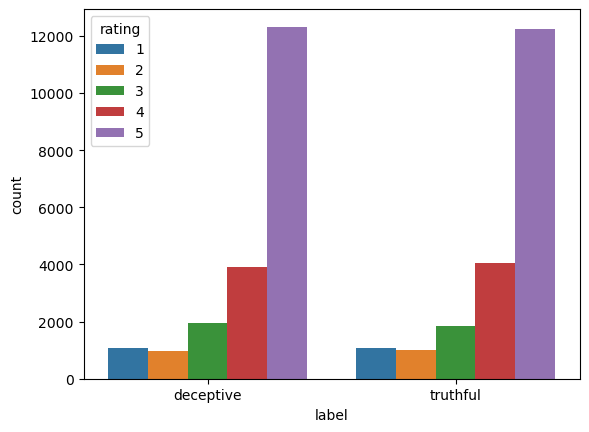

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x=df_test['label'], hue='rating', data = df_test)

In [112]:
x = df_test['text_']
y_val = df_test['label']

In [113]:
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x, padding = 'post', maxlen=maxlen)


In [114]:
len(x)

40432

In [115]:
y_pred = np.round(cnn_model.predict(x).ravel())
y_pred

1264/1264 [==============================] - 30s 24ms/step


array([0., 1., 0., ..., 0., 1., 1.], dtype=float32)

In [116]:
len(y_pred)

40432

In [117]:
y_pred_label_test = []
for i in y_pred:
    if i == 1:
        y_pred_label_test.append("truthful")
    else:
        y_pred_label_test.append("deceptive")

        
y_label_test = []
for i in y_val:
    if i == 1:
        y_label_test.append("truthful")
    else:
        y_label_test.append("deceptive")


In [118]:
len(y_pred_label_test)

40432

In [119]:
len(y_label_test)

40432

In [120]:
len(y_pred_label_test)

40432

In [121]:
len(y_label_test)

40432

In [122]:
len(df_test['text_'])

40432

In [123]:
predict_val = pd.DataFrame({'dataTest':df_test['text_'], 'Pred':y_pred_label_test, 'True_label':y_label_test}, columns=['dataTest','Pred','True_label'])
predict_val['result'] = np.where(predict_val['Pred']==predict_val['True_label'], 1, 0)
# results.sort_values(by='result').head(20)


predict_val.sort_values(by='result')

,dataTest,Pred,True_label,result
40431,"I work in the wedding industry and have to work long days, on my feet, outside in the heat, and have to look professional. I've spent a ridiculous amount of money on high end dress shoes like Merrels and just have not been able to find a pair that are comfortable to wear all day. Both for my feet and my back. Enter the Sanuk yoga sling!!! These shoes are amazingly comfortable. Though, I will admit it took a few wears to get used to the feel of the yoga matte bottom. At first, it felt a little ""sticky"" to me, and the fabric part that goes through the toe area was a little thick and took some getting used to. I wore them for a few days before taking them out on a job and I can't get over how comfortable they are. Ii have been wearing these shoes now for 3 months, every work day and I am THRILLED. No more back pain, no more sore feet. I also wear these sometimes during my off time,mans every time I wear them, I get compliments on how cute and comfortable they look. The great thing about these shoes is the yoga matte bottom. It helps your feet grip to the shoe a bit, so your foot can just walk normally, without having to grip the shoe. You may not realize it, but with a lot of Sandals, your foot is having to work to keep the shoe on, changing the way you walk and stand and ultimately causing foot and back pain. Not with these! Also, the soft linen sits comfortably on your skin and breathes nicely in the heat. The only downside is the funky tan lines, which is why I am sure to alternate shoes on my days off, especially if I plan to be outside for most of the day. If it were not for that, I think these might be the only shoes I'd wear all summer. If you are looking for a reasonable priced, comfortable shoe that you can wear and walk in all day.",truthful,deceptive,0
28242,"Sky High was a short and sweet read but it didn't exactly deliver all that I expected it to.\n\nSome books that I have read make every character seem important no matter how trivial their role was, but this book wasn't one of them. While reading this book, a lot of times I thought that a character wasn't a significant part of the book and this didn't just happen during the book, It also happened after I had finished it. I kept thinking about the book and all of the characters inside it and they just didn't seem important enough even though I know they were.\n\nWhat Im trying to say here is that, in my opinion, this book lacked some sort of execution or finesse that could have taken it from being just another good book to an amazing one. I never for one second doubt that C.J. Lake holds talent for story writing but all Im saying is that it needs a little bit more work.\n\nOther than that, the story was sweet, romantic and also quite hot. Even though a lot of characters appeared to be minor, I did love the main characters and the chemistry between those two. The relationship between those two was something to envy. Their banter, their romance, their attraction toward one another was extremely enjoyable to read.\n\nIn the end, I wouldnt say that reading this book was a waste of my time but I also won't be reading it a second time. Nevertheless, I will be reading other works of C.J. Lake to look for better versions of Sky High. And when I read one like that, let me tell you well have a winner on our hands.",truthful,deceptive,0
12710,This movie is unbelievable. It is an amazing story and a must see. If you are a fan of,truthful,deceptive,0
28241,"This is part two of a series and the first part is a prequel to the first one.\n\nI had a lot of fun with this book and I'm sure I will be reading part three in the series. I am very excited for part three to come out and I'm looking forward to the next book in the series.\n\nI received an ARC of this book from the author in exchange for an honest review.This book was great! It's very realistic. The characters were believable, the storyline was interesting. I liked the fact that it wa

In [124]:
wrong = 0
right = 0
for i in predict_val['result']:
    
    if i == 0:
        wrong+=1
    else:
        right+=1

print("The wrong guess is : ", wrong)
print("The right guess is: ", right)
    

The wrong guess is :  18032
The right guess is:  22400
